In [1]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset
from torchvision import transforms
from tqdm import tqdm
import cv2
# %run ConV_VAE.ipynb
# %run bigger_latent_space.ipynb
%run rgb200x200.ipynb
%run loader.ipynb
%run test.ipynb
%run train.ipynb

In [21]:
plt.rcParams['figure.dpi'] = 75
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
####### IMPORTANT ######
# set this flag to true if you want to load the model beforehand
load = False
# specify which model you want to load
model_name = None
img_size = 100
batch_size = 128
in_channels = 1
classes = 26

cuda


In [6]:
import torchvision

normalize = transforms.Lambda(lambda x: x / 255.0)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(img_size),
    normalize
])
train_data = CustomImageDataset('../data/sign_mnist_train.csv', transform=transform)
test_data = CustomImageDataset('../data/sign_mnist_test.csv', transform=transform)
# train_data = torchvision.datasets.MNIST('data/', train=True, transform=transforms.ToTensor())
# test_data = torchvision.datasets.MNIST('data/', train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [7]:
import numpy as np

model = cVAE((in_channels, img_size, img_size), classes).to(device)
# model = ConvVarAutoencoder()
BCE_loss = torch.nn.BCELoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0001)
img = np.zeros((img_size,img_size))
img[img_size//2,img_size//2] = 1
weights = torch.tensor(cv2.GaussianBlur(img, (img_size-3,img_size-3), 0)).to(device)
def loss(X, X_hat, mean, logvar):
    X = X * weights
    X_hat = X_hat * weights
    reconstruction_loss = BCE_loss(X_hat, X)
    KL_divergence = 0.5 * torch.sum(-1 - logvar + torch.exp(logvar) + mean ** 2)
    return reconstruction_loss + KL_divergence

In [9]:
import time

lr = 0.01
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=0.0001)
early_stop = EarlyStop(patience=5, save_name="100x100_conv_no_gauss_50_MNIST-gaussian.pt")


def adjust_lr(optimizer, decay_rate=0.95):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay_rate


max_epochs = 10
net = model.to(device)
if load:
    checkpoint = torch.load("model.pt", map_location=device)
    net.load_state_dict(checkpoint["net"])
    net.to(device)
    print("model loaded")
train_losses = []
print("training on ", device)
for epoch in range(max_epochs):

    train_loss, n, start = 0.0, 0, time.time()
    for X, y in tqdm(train_loader, ncols=50):
        X = X.to(device)
        y = y.to(device)
        X_hat, mean, logvar = net(X, y)
        # X_hat  = net(X)
        l = loss(X, X_hat, mean, logvar).to(device)
        # l = loss(X, X_hat).to(device)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        train_loss += l.cpu().item()
        n += X.shape[0]

    train_loss /= n
    train_losses.append(train_loss)
    print('epoch %d, train loss %.4f , time %.1f sec'
          % (epoch, train_loss, time.time() - start))

    adjust_lr(optimizer)

    if (early_stop(train_loss, net, optimizer)):
        break

training on  cuda


100%|███████████| 469/469 [00:18<00:00, 26.05it/s]


epoch 0, train loss 2.5405 , time 18.0 sec
model saved


100%|███████████| 469/469 [00:15<00:00, 30.13it/s]


epoch 1, train loss 2.5218 , time 15.6 sec
model saved


100%|███████████| 469/469 [00:15<00:00, 30.27it/s]


epoch 2, train loss 2.5214 , time 15.5 sec
model saved


100%|███████████| 469/469 [00:17<00:00, 26.52it/s]


epoch 3, train loss 2.5212 , time 17.7 sec
model saved


100%|███████████| 469/469 [00:17<00:00, 26.65it/s]


epoch 4, train loss 2.5210 , time 17.6 sec
model saved


100%|███████████| 469/469 [00:15<00:00, 29.33it/s]


epoch 5, train loss 2.5209 , time 16.0 sec
model saved


100%|███████████| 469/469 [00:16<00:00, 28.25it/s]


epoch 6, train loss 2.5209 , time 16.6 sec
model saved


100%|███████████| 469/469 [00:16<00:00, 28.66it/s]


epoch 7, train loss 2.5208 , time 16.4 sec
model saved


100%|███████████| 469/469 [00:16<00:00, 28.88it/s]


epoch 8, train loss 2.5208 , time 16.2 sec
model saved


100%|███████████| 469/469 [00:16<00:00, 28.42it/s]

epoch 9, train loss 2.5207 , time 16.5 sec
model saved


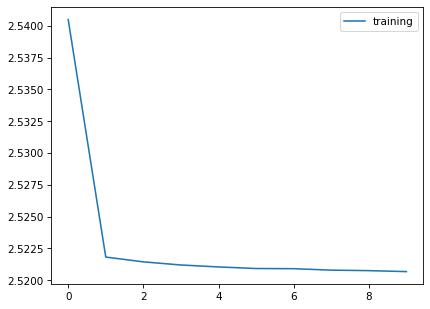

In [10]:
plt.plot(train_losses, label="training")
plt.legend()
plt.show()

In [22]:
from matplotlib import cm

checkpoint = torch.load("100x100_rgb_capable_50epochs-nogaussain.pt", map_location=device)
net = cVAE((in_channels, img_size, img_size), classes).to(device)
net.load_state_dict(checkpoint["net"])
net.to(device)
net.eval()

cVAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (14): Flatten()
      (15): MLP(
    

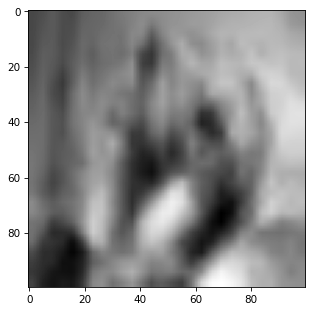

In [31]:
number = 8
with torch.no_grad():
    x = net.generate(number)
x = x.transpose(0, 2).transpose(0, 1)
x = x.squeeze(2).cpu().numpy()
plt.imshow(x, cm.gray)
# x = x * 255
#cv2.imwrite(str(number) + '.png', x)

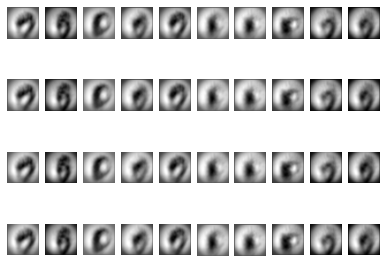

In [17]:
classes = 10
rows = 4
with torch.no_grad():
    x = net.generate(torch.tensor([list(range(classes))] * rows).clone().view(-1))
for i in range(classes*rows):
    plt.subplot(rows, classes, i + 1)
    plt.axis("off")
    img = x[i].transpose(0, 2).transpose(0, 1)
    plt.imshow(img.squeeze(0).cpu().numpy(), cm.gray)

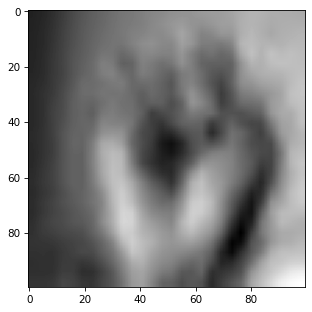

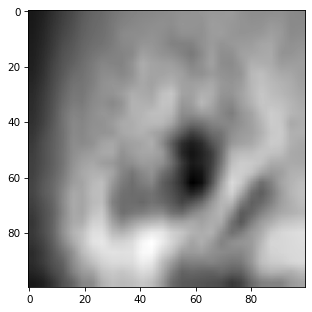

KeyboardInterrupt: 

In [6]:
import random
import time
random.seed(42)
images = []
labels = np.arange(26).repeat(2)
random.shuffle(labels)
labels = torch.tensor(labels)
for number in labels:
    x = net.generate(number)
    x = x.transpose(0, 2).transpose(0, 1)
    x = x.squeeze(2).cpu().detach().numpy()
    images.append(x)
y_pred = []
for i, image in enumerate(images):
    #image = cv2.resize(image, (200,200))
    plt.imshow(image,cm.gray)
    plt.show(block=False)
    time.sleep(1)
    key = input()
    if key == 'stop':
        break
    y_pred.append([key, labels[i].detach().numpy()])
    # cv2.destroyAllWindows()
    plt.close()

In [ ]:
print(y_pred)


In [86]:
conv = []
for (letter, label) in y_pred:
    if len(letter) == 1:
        conv.append(ord(letter) - ord('a'))
    else:
        conv.append(-1)

In [87]:

z= zip(conv, y_pred)
for x in z:
    print(x)

(18, ['s', array(4)])
(5, ['f', array(11)])
(13, ['n', array(12)])
(1, ['b', array(1)])
(17, ['r', array(10)])
(23, ['x', array(19)])
(8, ['i', array(8)])
(3, ['d', array(19)])
(16, ['q', array(9)])
(5, ['f', array(5)])
(23, ['x', array(23)])
(18, ['s', array(12)])
(13, ['n', array(16)])
(14, ['o', array(14)])
(15, ['p', array(15)])
(22, ['w', array(21)])
(2, ['c', array(2)])
(14, ['o', array(14)])
(11, ['l', array(5)])
(13, ['n', array(13)])
(0, ['a', array(18)])
(0, ['a', array(0)])
(21, ['v', array(22)])
(20, ['u', array(9)])
(10, ['k', array(21)])
(17, ['r', array(25)])
(20, ['u', array(17)])
(24, ['y', array(24)])
(15, ['p', array(15)])
(11, ['l', array(10)])
(11, ['l', array(11)])
(8, ['i', array(6)])
(22, ['w', array(25)])
(23, ['x', array(16)])
(21, ['v', array(22)])
(0, ['a', array(6)])
(17, ['r', array(20)])
(12, ['m', array(24)])
(1, ['b', array(1)])
(18, ['s', array(13)])
(12, ['m', array(18)])
(2, ['c', array(2)])
(17, ['r', array(17)])
(10, ['k', array(3)])
(4, ['e', arra

In [19]:
text = input("What phrase would you like to see?").lower()
import time
start_time = time.time()
for i, letter in enumerate(text):
    if letter == ' ':
        x = torch.zeros((200,200))
    else:
        number = ord(letter) - ord('a')
        x = net.generate(number)
        x = x.transpose(0, 2).transpose(0, 1)
        x = x.squeeze(2).cpu().detach().numpy()
    plt.subplot(1, len(text), i + 1)
    plt.axis("off")
    plt.imshow(x, cm.gray)
print("--- %s seconds ---" % (time.time() - start_time))


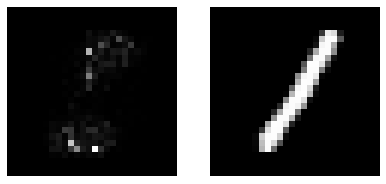

In [39]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)

for batch in train_loader:
    X, y = batch
    X = X.to(device)
    y = y.to(device)
    x, mean, logvar = net(X, y)
    x = x.transpose(0, 2).transpose(0, 1)
    x = x.squeeze(2).squeeze(0).cpu().detach().numpy()
    #x = x.reshape()
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.imshow(x, cm.gray)
    plt.subplot(1, 2, 2)
    plt.axis("off")
    img = X#.transpose(0, 2).transpose(0, 1)
    plt.imshow(img.squeeze(0).squeeze(0).cpu().numpy(), cm.gray)
    break